<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
New Python Based Pipeline for Trodes
"""

'\nNew Python Based Pipeline for Trodes\n'

In [ ]:
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Finde APs """
""" Find IIS """


' Find IIS '

In [ ]:
import os
import subprocess
import numpy as np
trodes_dat_reader_loc = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\Resources\TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    return np.memmap(npy_filename, dtype=dtype, mode='r', offset=offset, shape=shape)



C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\Resources\TrodesToPython\readTrodesExtractedDataFile3.py:41: SyntaxWarning: invalid escape sequence '\s'
  sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\Resources\TrodesToPython\readTrodesExtractedDataFile3.py:51: SyntaxWarning: invalid escape sequence '\*'
  temptypes = re.split('\*', sep[i+1])


In [ ]:
""" Generate RAW_LFP Binaries from *.rec files"""
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\Test_Emily\AngelfoodCake01\AngelfoodCake01.rec'
full_cmd_raw = ' '.join([export_func_location, '-raw',
                    '-rec ', dot_rec_file_loc,
                    '-userawrefs', str(0),
                    '-outputdirectory', dest_dir])
# export_report = subprocess.run(full_cmd_raw)



In [ ]:


animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')


In [ ]:
""" Import RAW_LFP """
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'


dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA\AngelfoodCake01.raw\AngelfoodCake01.raw_group0.dat'
# dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])

num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]

os.chdir(r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze')

memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
lfp_disk_array = dot_dat_data['data']['voltage'].astype('float16')
lfp_disk_array*=voltage_scaling
raw_npy_filename = os.path.join(my_analysis_dir,animal_session+'_raw_lfp.npy')
np.save(raw_npy_filename, lfp_disk_array)


Text(0.5, 0, 'Time (s)')

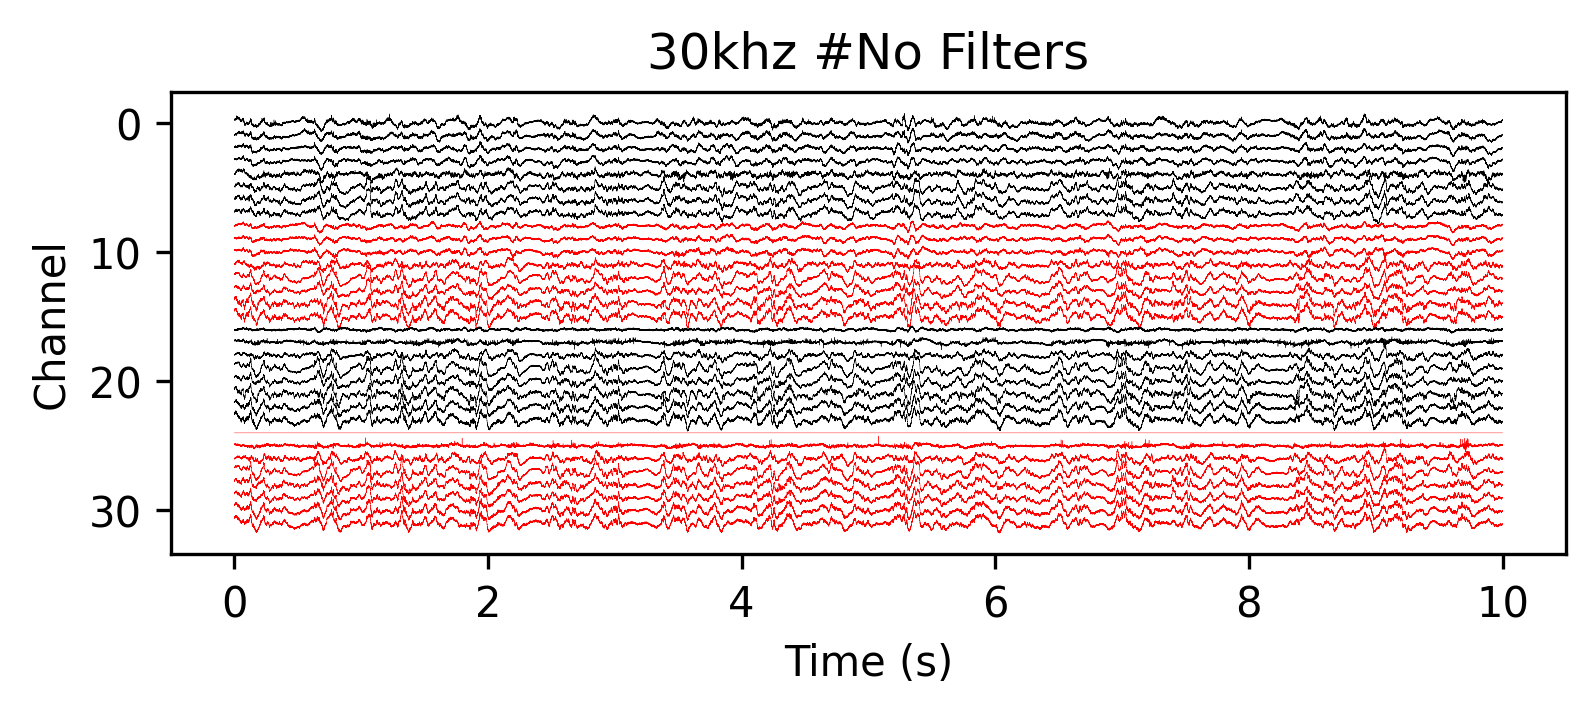

In [ ]:
SR = 30000
x = np.random.randint(0,lfp_disk_array.shape[0])
t_wind  = [x,x+10*SR]
t_ind = np.arange(t_wind[0],t_wind[1])

from matplotlib import pyplot as plt
v_samp = lfp_disk_array[t_ind,:]
v_samp = v_samp / np.max(np.abs(v_samp),axis=0) *.75
ch = np.arange(0,32)+1
v_samp = (v_samp.transpose()-v_samp[:,24]).transpose()

colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
time_sec = (t_ind-t_ind[0])/SR
fig,ax = plt.subplots(figsize=(6,2),dpi=300)
for ch in np.arange(v_samp.shape[1]):
    _ = ax.plot(time_sec,v_samp[:,ch]+ch,linewidth=.1,color = colors[ch])
ax.invert_yaxis()
ax.set_title('30khz #No Filters')
ax.set_ylabel('Channel')
ax.set_xlabel('Time (s)')

In [ ]:
"""
DOWN SAMPLE & SAVE
"""
# lfp_disk_array = load_npy_to_memmap(raw_npy_filename)
default_sample_rate = 30000
downsampled_rate = 5000
downsample_factor = default_sample_rate/target_sample_rate

downsample_indicies = np.arange(0,lfp_disk_array.shape[0],downsample_factor,dtype='int')
ds_array=lfp_disk_array[downsample_indicies,:]
npy_downsamp_filename = raw_npy_filename.replace('raw', 'downsamp')
np.save(npy_downsamp_filename, ds_array)
np.save('downsampled_rate.npy',downsampled_rate)

In [ ]:
downsampled_rate = 5000
np.save('downsampled_rate.npy',downsampled_rate)
downsampled_rate = np.load('downsampled_rate.npy')
print(downsampled_rate)

5000


In [ ]:
def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()

display_filter(fir_coeff,downsampled_rate)

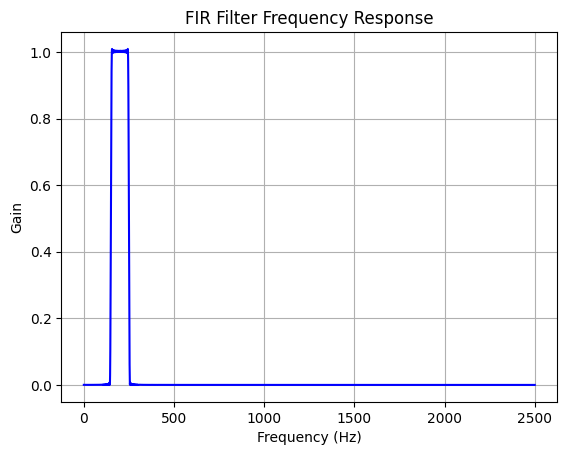

In [ ]:
"""
BAND PASS FOR RIPPLES
"""

import scipy as sci
import matplotlib.pyplot as plt


# Sampling frequency
downsampled_rate = int(np.load('downsampled_rate.npy'))


# Desired passband frequencies (150-250 Hz)
passband = [150, 250]


# Estimate filter order
numtaps = 1200  # Number of filter coefficients (adjust as needed)
fir_coeff = sci.signal.firwin(numtaps, [150,250], width=10, window='hamming', pass_zero='bandpass', scale=True, fs=downsampled_rate)



In [ ]:
# Apply the FIR filter using filtfilt for zero-phase filtering across all channels
filtered_data = signal.filtfilt(fir_coeff, 1.0, mmap_array[t_ind,:], axis=0)
# filtered_data = mmap_array[t_ind,:]
# filtered_data=(filtered_data.transpose() - filtered_data[:,24]).transpose()
spike_bool = filtered_data<-70


fig,ax = plt.subplots(figsize=(6,4),dpi=300)

filtered_data = filtered_data/np.max(np.abs(filtered_data),axis=0) * .8

# Filtered signal
for ch in np.arange(filtered_data.shape[1]):
    ax.plot(time_sec[:3000],filtered_data[:3000,ch]+ch,linewidth=.3,color = colors[ch])
    spike_times = time_sec[:3000][spike_bool[:3000,ch]]
    plt.scatter( spike_times,np.ones_like( spike_times)*ch+-.25,s=3,marker='o',color='m'  )
    ax.set_title('Spike(MUA) Detection Signal')
ax.invert_yaxis()
ax.set_ylabel('Channel')
ax.set_xlabel('Time (s)')
